<a href="https://colab.research.google.com/github/JBalbuenaG/proyecto_DL/blob/main/02_VGG16_for_KDEF_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, glob

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
X_train = np.load('/content/drive/My Drive/Examen_DL/data/X_train_KDEF-emotions.npy')
Y_train = np.load('/content/drive/My Drive/Examen_DL/data/Y_train_KDEF-emotions.npy')
X_valid = np.load('/content/drive/My Drive/Examen_DL/data/X_valid_KDEF-emotions.npy')
Y_valid = np.load('/content/drive/My Drive/Examen_DL/data/Y_valid_KDEF-emotions.npy')

In [3]:
# emotions keys()
emo_dict = {0: 'happy', 1: 'sad',
                     2: 'surprise', 3: 'fear',
                     4: 'disgust-contempt', 5: 'anger'}

In [4]:
#Set image size because the image are too large
IMAGE_SIZE = [200,200]
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE+[3],
    weights='imagenet',
    include_top=False)

ptm.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [5]:
#map the data into features vectors
K = len(emo_dict) #number of classes
x = Flatten()(ptm.output)
#x = Dense(K,activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

#Definición para el calculo de metricas multi-clase
def calculo_metricas(CM, emociones):
    
    emocion = []
    TruPos = []
    FalPos = []
    FalNeg = []
    TruNeg = []
    acc = []
    prec = []
    recall = []
    f1 = []
    
    total = np.sum(CM)
    
    for i in range(len(emociones)):
       
        TP = CM[i][i]
        FP = sum(CM[:,i])-TP
        FN = sum(CM[i,:])-TP
        TN = total - TP-FN-FP
        a = (TP+TN)/(TP+TN+FN+FP)
        p = TP/(TP+FP)
        r = TP/(TP+FN)
        f = 2*(r*p)/(r+p)
        
        emocion.append(emociones[i])
        TruPos.append(TP)
        FalPos.append(FP)
        TruNeg.append(TN)
        acc.append(a)
        prec.append(p)
        recall.append(r)
        f1.append(f)
    
    metricas = pd.DataFrame()
    metricas['Emociones']=emocion
    metricas['Accuracy']=acc
    metricas['Precision']=prec
    metricas['Recall']=recall
    metricas['F1-Score']=f1
    
    return metricas

def graf_confusion_matrix(CM, emociones,emb):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(CM,annot=True,fmt='',xticklabels=emociones,yticklabels=emociones, ax=ax, cmap='Blues');
    ax.set_title('Matriz de confusión '+emb);
    ax.set_xlabel('Valores Predecidos');
    ax.set_ylabel('Valores Verdaderos');
    
def graficar_historia_entrenamiento(log):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(log.history['val_loss'], label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(log.history['val_accuracy'], label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    #ax2.set_ylim((0.0, 1.0))
    for ax in axes: ax.legend()

In [7]:
feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))
D = feat.shape[1]

#Modelo de red neuronal para clasificación binaria
i = Input(shape=(D,))
x = Dense(4096, activation='relu')(i)
x = Dropout(0.2)(x)
x = Dense(4096, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

emo_model = Model(i ,x)

emo_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)


In [8]:
r = emo_model.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid,Y_valid)
)

Epoch 1/10
27/27 [==============================] - 36s 1s/step - loss: 11.1560 - accuracy: 0.2391 - val_loss: 1.5144 - val_accuracy: 0.3607
Epoch 2/10
27/27 [==============================] - 38s 1s/step - loss: 1.3824 - accuracy: 0.4220 - val_loss: 1.2403 - val_accuracy: 0.4774
Epoch 3/10
27/27 [==============================] - 39s 1s/step - loss: 1.1134 - accuracy: 0.5381 - val_loss: 1.0856 - val_accuracy: 0.5643
Epoch 4/10
27/27 [==============================] - 39s 1s/step - loss: 0.9142 - accuracy: 0.6397 - val_loss: 1.0049 - val_accuracy: 0.5940
Epoch 5/10
27/27 [==============================] - 38s 1s/step - loss: 0.7339 - accuracy: 0.7147 - val_loss: 0.9483 - val_accuracy: 0.6226
Epoch 6/10
27/27 [==============================] - 38s 1s/step - loss: 0.6448 - accuracy: 0.7442 - val_loss: 0.9449 - val_accuracy: 0.6226
Epoch 7/10
27/27 [==============================] - 39s 1s/step - loss: 0.5441 - accuracy: 0.7921 - val_loss: 0.9556 - val_accuracy: 0.6321
Epoch 8/10
27/27 [=

In [9]:
p = emo_model.predict(X_valid)
pred = np.argmax(p, axis=1)

Y_valid = Y_valid.astype(int)


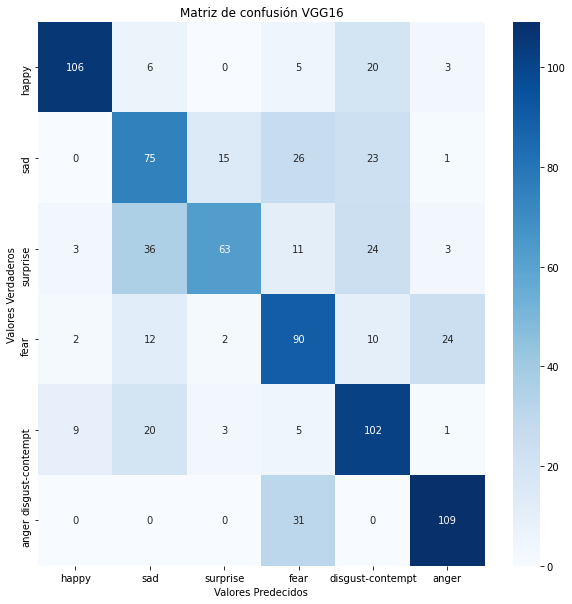

In [10]:
emo_dict = {0: 'happy', 1: 'sad', 2: 'surprise', 3: 'fear', 4: 'disgust-contempt', 5: 'anger'}
emociones_1 = list(emo_dict.values())

CM_VGG = confusion_matrix(Y_valid, pred)
graf_confusion_matrix(CM_VGG, emociones_1 ,'VGG16')


In [11]:
m1 = calculo_metricas(CM_VGG, emociones_1)
m1


,Emociones,Accuracy,Precision,Recall,F1-Score
0,happy,0.942857,0.883333,0.757143,0.815385
1,sad,0.834524,0.503356,0.535714,0.519031
2,surprise,0.884524,0.759036,0.450000,0.565022
3,fear,0.847619,0.535714,0.642857,0.584416
4,disgust-contempt,0.863095,0.569832,0.728571,0.639498
5,anger,0.925000,0.773050,0.778571,0.775801


In [12]:
emo_model.save('mod_VGG16_emotions_KDEF_tst01.h5')